
# üöÄ Introducci√≥n al A/B Testing

Objetivo: En este notebook exploraremos c√≥mo formular y verificar hip√≥tesis de negocio, realizar pruebas A/B, y priorizar experimentos para optimizar decisiones basadas en datos. Estructura del notebook:

- Fundamentos te√≥ricos
- Ejemplo de prueba A/B con explicaci√≥n detallada
- Priorizar hip√≥tesis usando WSJF, ICE y RICE
- Teor√≠a complementaria sobre pruebas y dise√±o experimental




# üìä Fundamentos Estad√≠sticos

Un test A/B compara dos grupos (A y B) para ver si existe **una diferencia estad√≠sticamente significativa**.

### Hip√≥tesis
- $H_0$: No hay diferencia entre A y B (la variante no mejora nada).
- $H_1$: S√≠ hay diferencia (la variante mejora).

Usamos un **nivel de significancia** (Œ± = 0.05 generalmente).




# üìÇ Cargar y explorar los datos


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Activamos el estilo de fondo oscuro
plt.style.use("dark_background")

# Dataset para prueba A/B
data_ab = pd.DataFrame({
    'date': pd.date_range(start='2025-01-01', periods=100),
    'group': np.random.choice(['A', 'B'], size=100),
    'visitors': np.random.poisson(100, size=100),
    'orders': np.random.binomial(n=np.random.poisson(100, size=100), p=0.1)
})

# Dataset para WSJF
hypothesis_wsjf = pd.DataFrame({
    'hypothesis': ['Hip1', 'Hip2', 'Hip3', 'Hip4'],
    'user_business_value': [8, 5, 3, 9],
    'time_criticality': [7, 6, 4, 8],
    'risk_reduction_opportunity_enablement': [5, 7, 6, 4],
    'job_size': [3, 2, 5, 4]
})

# Dataset para ICE
hypothesis_ice = pd.DataFrame({
    'hypothesis': ['Hip1', 'Hip2', 'Hip3', 'Hip4'],
    'impact': [9, 6, 4, 8],
    'confidence': [8, 9, 5, 7],
    'efforts': [4, 3, 5, 6]
})

# Dataset para RICE
hypothesis_rice = pd.DataFrame({
    'hypothesis': ['Hip1', 'Hip2', 'Hip3', 'Hip4'],
    'reach': [1000, 800, 600, 1200],
    'impact': [9, 6, 4, 8],
    'confidence': [8, 9, 5, 7],
    'efforts': [4, 3, 5, 6]
})



# üîç A/B Testing
Objetivo: Medir la diferencia en la tasa de conversi√≥n entre el grupo A (control) y el grupo B (variante). 

Pasos:
1. Resumir datos por grupo.
2. Calcular la m√©trica clave: √≥rdenes por visitante.
3. Interpretar si hay diferencias relevantes.


In [16]:
# Paso 1: Mostrar primeras filas del dataset
data_ab.head(5)

date group  visitors  orders
0 2025-01-01     A        96      10
1 2025-01-02     A       106      13
2 2025-01-03     B        94       7
3 2025-01-04     A       116      11
4 2025-01-05     B       102      13

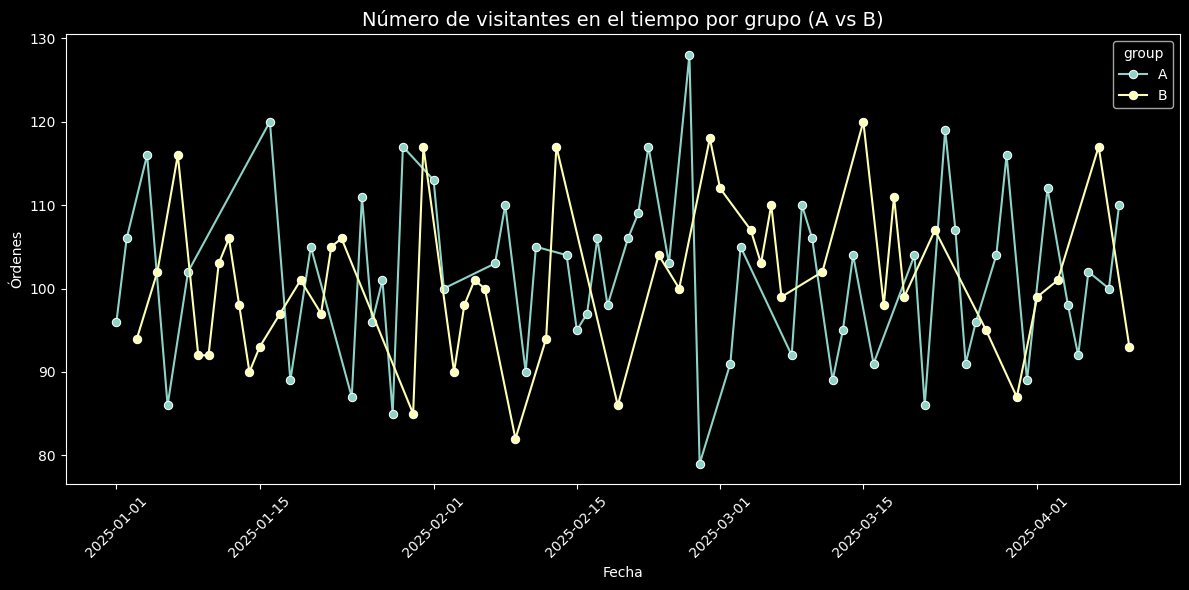

In [17]:
# Gr√°fico con seaborn: n√∫mero de visitantes en el tiempo por grupo
plt.figure(figsize=(12,6))
sns.lineplot(data=data_ab, x='date', y='visitors', hue='group', marker='o')
plt.title("N√∫mero de visitantes en el tiempo por grupo (A vs B)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("√ìrdenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

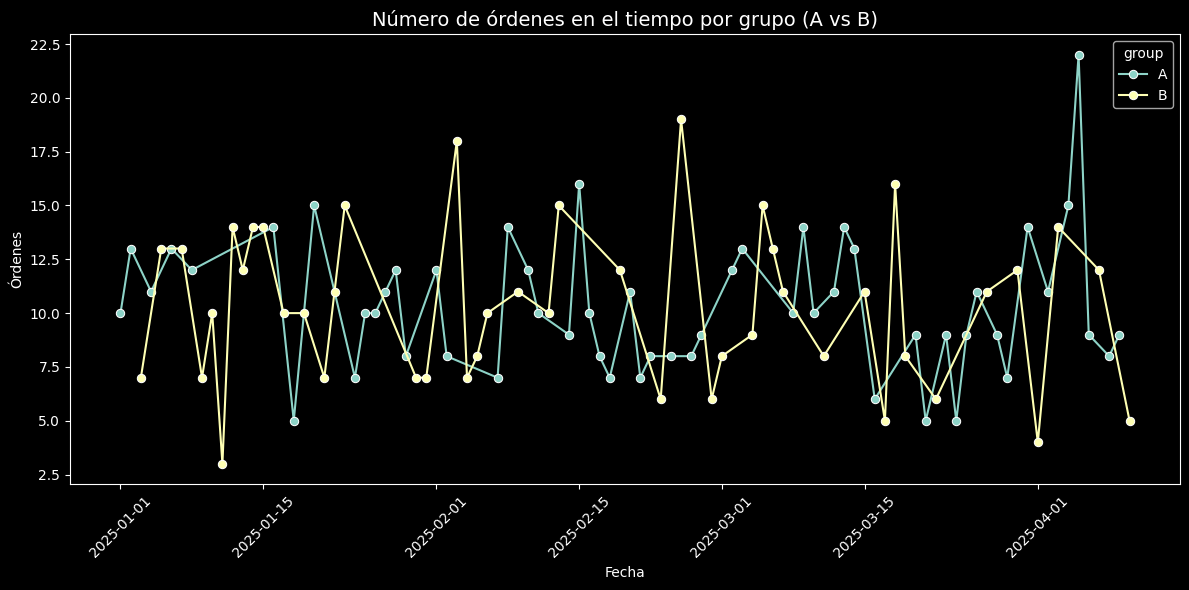

In [18]:
# Gr√°fico con seaborn: n√∫mero de √≥rdenes en el tiempo por grupo
plt.figure(figsize=(12,6))
sns.lineplot(data=data_ab, x='date', y='orders', hue='group', marker='o')
plt.title("N√∫mero de √≥rdenes en el tiempo por grupo (A vs B)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("√ìrdenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
data_ab.groupby('group').agg({'visitors': 'sum', 'orders': 'sum'}).reset_index()

group  visitors  orders
0     A      5589     570
1     B      4544     464

In [20]:
# Paso 2: Agrupar y sumar visitantes y √≥rdenes por grupo
table_ab = (
    data_ab.drop(columns=['date'])
           .groupby('group', as_index=False)
           .agg({'visitors': 'sum', 'orders': 'sum'})
)

table_ab.head()

group  visitors  orders
0     A      5589     570
1     B      4544     464

Una gr√°fica ayuda a ver r√°pidamente si parece haber una diferencia.  
¬°Pero cuidado! Lo visual no siempre es estad√≠sticamente significativo üòâ


In [21]:
# Paso 3: Calcular tasa de conversi√≥n y mostrar resultados
table_ab['orders_to_visitors_ratio'] = table_ab['orders'] / table_ab['visitors']
print(table_ab)

  group  visitors  orders  orders_to_visitors_ratio
0     A      5589     570                  0.101986
1     B      4544     464                  0.102113



# üß™ Frameworks de priorizaci√≥n de hip√≥tesis

¬øC√≥mo se por donde empezar?

**Recordemos que una vez yo ya tengo mi hipotesis, para probar estad√≠sticamente si son validas o no puedo hacer lo siguiente:**

Aplicamos pruebas como **t-test** o **chi-cuadrado** (dependiendo del tipo de variable) y la idea es calcular un **p-value**:

- Si $p < Œ±$: Rechazamos $H_0$ ‚Üí Hay diferencia significativa.
- Si $p ‚â• Œ±$: No hay suficiente evidencia ‚Üí No podemos rechazar $H_0$.


In [27]:
# Separar √≥rdenes por grupo
orders_A = data_ab.loc[data_ab['group'] == 'A', 'orders']
orders_B = data_ab.loc[data_ab['group'] == 'B', 'orders']

# Test de Levene para igualdad de varianzas
levene_stat, levene_p = stats.levene(orders_A, orders_B)
print(f"Levene test p-value: {levene_p:.4f}")

# Decisi√≥n sobre varianzas
if levene_p < 0.05:
    print("‚ùå Varianzas distintas ‚Üí usamos t-test con equal_var=False")
    equal_var = False
else:
    print("‚úÖ Varianzas iguales ‚Üí usamos t-test con equal_var=True")
    equal_var = True

# Prueba t de Student seg√∫n resultado de Levene
t_stat, p_value = stats.ttest_ind(orders_A, orders_B)
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretaci√≥n
alpha = 0.05
if p_value < alpha:
    print("Rechazamos H0: existe diferencia significativa entre A y B ‚úÖ")
else:
    print("No podemos rechazar H0: no hay diferencia significativa ‚ùå")


Levene test p-value: 0.1149
‚úÖ Varianzas iguales ‚Üí usamos t-test con equal_var=True

t-statistic: 0.0761
p-value: 0.9395
No podemos rechazar H0: no hay diferencia significativa ‚ùå


### 3.1 WSJF (Weighted Shortest Job First)
F√≥rmula: 
$$
WSJF = \frac{\text{ValorNegocio} + \text{Urgencia} + \text{Riesgo}}{\text{Tama√±oTrabajo}}
$$
Donde:
- **ValorNegocio:** Beneficio esperado.
- **Urgencia:** Cr√≠ticas del mercado.
- **Riesgo:** Oportunidad de reducci√≥n de riesgo.
- **Tama√±oTrabajo:** Esfuerzo estimado.


In [23]:
hypothesis_wsjf.head()

hypothesis  user_business_value  time_criticality  \
0       Hip1                    8                 7   
1       Hip2                    5                 6   
2       Hip3                    3                 4   
3       Hip4                    9                 8   

   risk_reduction_opportunity_enablement  job_size  
0                                      5         3  
1                                      7         2  
2                                      6         5  
3                                      4         4

In [24]:
# C√°lculo de WSJF y ordenamiento
hypothesis_wsjf['WSJF'] = (
    hypothesis_wsjf['user_business_value'] + 
    hypothesis_wsjf['time_criticality'] + 
    hypothesis_wsjf['risk_reduction_opportunity_enablement']
) / hypothesis_wsjf['job_size']

print(hypothesis_wsjf[['hypothesis', 'WSJF']].sort_values(by='WSJF', ascending=False))


  hypothesis      WSJF
1       Hip2  9.000000
0       Hip1  6.666667
3       Hip4  5.250000
2       Hip3  2.600000


### 3.2 ICE (Impact, Confidence, Ease)
F√≥rmula: 
$$
ICE = \frac{Impact \times Confianza}{Esfuerzo}
$$

Donde:
- **Impacto:** Crecimiento esperado.
- **Confianza:** Nivel de certeza en la estimaci√≥n.
- **Esfuerzo:** Recursos necesarios.

In [25]:
# C√°lculo de ICE y ordenamiento
hypothesis_ice['ICE'] = (
    hypothesis_ice['impact'] * hypothesis_ice['confidence']
) / hypothesis_ice['efforts']
print(hypothesis_ice[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))


  hypothesis        ICE
0       Hip1  18.000000
1       Hip2  18.000000
3       Hip4   9.333333
2       Hip3   4.000000


### 3.3 RICE (Reach, Impact, Confidence, Effort)
F√≥rmula: 

$$
RICE = \frac{Reach \times Impact \times Confianza}{Esfuerzo}
$$

Donde:
- **Reach:** Usuarios afectados.
- **Impact:** Mejora por usuario.
- **Confianza:** Precisi√≥n de las estimaciones.
- **Esfuerzo:** Recursos necesarios.

In [26]:
# C√°lculo de RICE y ordenamiento
hypothesis_rice['RICE'] = (
    hypothesis_rice['reach'] * hypothesis_rice['impact'] * hypothesis_rice['confidence']
) / hypothesis_rice['efforts']
print(hypothesis_rice[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))


  hypothesis     RICE
0       Hip1  18000.0
1       Hip2  14400.0
3       Hip4  11200.0
2       Hip3   2400.0



# ü§î Interpretaci√≥n de Resultados

El **p-value** nos dice si la diferencia observada probablemente sea **real** o solo un producto del azar.

üëâ Aqu√≠ es donde traducimos los n√∫meros en **decisiones de negocio**.



## ‚ö†Ô∏è Problemas comunes en A/B Testing

- Tama√±o de muestra insuficiente (¬°puedes sacar conclusiones err√≥neas!).
- M√∫ltiples tests a la vez ‚Üí aumenta la probabilidad de falsos positivos.
- Sesgos en la asignaci√≥n de grupos.

üí° Recuerda: **Un mal dise√±o arruina cualquier an√°lisis**.



## Cierre y Conclusiones

- El A/B Testing combina **estad√≠stica + negocio**.
- No basta con mirar n√∫meros ‚Üí hay que interpretar en contexto.
- La pr√°ctica continua mejora tu criterio como analista.

üôã‚Äç‚ôÄÔ∏è Preguntas finales ‚Üí ¬°Abrimos discusi√≥n!
